In [ ]:
# from google.colab import drive # 挂载谷歌云盘
# drive.mount('/content/drive')
# !nvidia-smi # 显示显卡信息
# ''' 符号%代表一直生效，！代表执行完立马结束，不会生效，所以进入目录用% '''
# %cd /content/drive/MyDrive/timeSerise
# ''' 支持的 常用命令1.ls  2.wget  3.gdoint(int(int(int(w))))n  4.mkdir  5.pwd '''
# !ls
# !pip install patool
# !pip install sktime
# !pip install reformer_pytorch

In [45]:
import random
import numpy as np
import torch
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
# from exp.exp_imputation import Exp_Imputation
# from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
# from exp.exp_anomaly_detection import Exp_Anomaly_Detection
# from exp.exp_classification import Exp_Classification
# from data_provider.data_creat import *
# import akshare as ak
from torch.utils.tensorboard import SummaryWriter

import os
import numpy as np
import pandas as pd
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from utils.timefeatures import time_features
from data_provider.m4 import M4Dataset, M4Meta
from data_provider.uea import subsample, interpolate_missing, Normalizer
from sktime.datasets import load_from_tsfile_to_dataframe
import warnings

warnings.filterwarnings('ignore')

In [81]:
class Args:
    '''基本配置'''
    # 选项：[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
    task_name = 'long_term_forecast'
    model_id = 'stock_cy'
    des = '20231210' # 实验描述 20231210
    # 模型名称，选项：[Autoformer, Transformer, TimesNet]
    model = 'TimesNet'

    '''数据加载'''
    # 数据集类型,选项：[ETTh1,ETTh2,ETTm1,ETTm2,custom,m4,PSM,MSL,SMAP,SMD,SWAT,UEA]
    data = 'custom'
    test_path = 'test.csv'
    root_path = './dataset/Stock/'
    data_path = 'stock_cy_all_raw.csv'
    # 预测任务 M:多变量预测多变量, S:单变量预测单变量, MS:多变量预测单变量
    features = 'MS'
    # 目标列名，S或MS任务中的目标特征
    target = 'Close'
    # 时间采集粒度，选项：[s:秒, t:分钟, h:小时, d:天, b:工作日, w:周, m:月]
    freq = 'd'
    # 模型检查点的位置
    checkpoints = './checkpoints/'
    
    '''是否训练模型'''
    is_training = 0 # 设置为1则进行训练，设置为0则进行测试
    # 测试集的比例
    if is_training:
        test_ratio = [0.2,0.1] # test测试集、valid验证集的占比
    else:
        test_ratio = [0.3,0.3]
        data_path = test_path
    scale = True # dataset获取的源数据是否进行归一化
    pred_once = True # 是否只预测一次，用于测试集数据

    '''预测任务'''
    # 输入序列长度,这是用于模型训练的输入序列的长度
    seq_len = 60
    # 开始标记长度,这是模型输出目标中有标签数据的长度，类似于滑动窗口的长度
    label_len = 20
    # 预测序列长度
    pred_len = 20
    # 季节模式（针对M4数据集）
    seasonal_patterns = 'Monthly'
    inverse = False    # 反转输出数据

    '''插补任务'''
    # 插补任务中数据丢失率
    mask_rate = 0.25

    '''异常检测任务'''
    # 异常检测中异常点占比
    anomaly_ratio = 0.25

    '''模型定义'''
    # TimesBlock 中傅里叶变换,频率排名前k个周期
    top_k = 5
    # Inception 中卷积核个数
    num_kernels = 6
    # encoder 输入特征数
    enc_in = 31
    # decoder 输入特征数
    dec_in = 31
    # 输出通道数
    c_out = 31
    # 线性层隐含神经元个数
    d_model = 32
    # FFN 层隐含神经元个数
    d_ff = 32
    # 多头注意力机制
    n_heads = 8
    # encoder 层数
    e_layers = 2
    # decoder 层数
    d_layers = 1
    # 滑动窗口长度
    moving_avg = 20
    # 对 Q 进行采样，对 Q 采样的因子数
    factor = 3
    # 是否下采样操作 pooling
    distil = True
    # dropout 率
    dropout = 0.1
    # 时间特征嵌入方式,选项：[timeF, fixed, learned]
    embed = 'timeF'
    # 激活函数类型
    activation = 'gelu'
    # 是否输出 attention
    output_attention = False

    '''优化'''
    # 并行核心数
    num_workers = 0
    # 实验轮数
    itr = 1
    # 训练迭代次数
    train_epochs = 500
    # batch size 大小
    batch_size = 256
    # early stopping 机制容忍次数
    patience = 5
    # 学习率
    learning_rate = 0.0001
    # 损失函数
    loss = 'MSE'
    # 学习率下降策略
    lradj = 'type1'
    # 使用混合精度训练
    use_amp = False

    '''GPU'''
    # 使用 gpu
    use_gpu = True
    gpu = 0
    # 使用多个 gpus
    use_multi_gpu = False
    # 多 gpu 的设备 id
    devices = '0,1,2,3'

    '''去平稳化投影仪参数'''
    # 投影仪的隐藏层维度（列表）
    p_hidden_dims = [128, 128]
    # 投影仪中的隐藏层数
    p_hidden_layers = 2


# 创建参数对象
args = Args()

# 设置随机种子以确保结果可重现
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)


# 获取列数
num_columns = 32
# args.des = NUM
args.enc_in = num_columns - 1
args.dec_in = num_columns - 1
args.c_out = num_columns - 1

# 检查并设置 GPU
args.use_gpu = torch.cuda.is_available() and args.use_gpu
if args.use_gpu:
    print("使用 GPU.")
    total_cuda_devices = torch.cuda.device_count()  # 获取系统中可用的 GPU 总数
    print(f"系统中总共有 {total_cuda_devices} 个 CUDA 设备可用。")
    if args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]

        # 打印多 GPU 使用情况
        print(f"使用多个GPU: {args.device_ids}")
        device = torch.device(f"cuda:{args.gpu}" if args.use_gpu else "cpu")
        print(f"Primary GPU (cuda:{args.gpu}) is in use.")
    else:
        args.gpu = 0
        device = torch.device("cuda" if args.use_gpu else "cpu")
        print("使用单个 GPU.")
else:
    device = torch.device("cpu")
    print("使用 CPU.")


# 选择合适的实验类
if args.task_name == 'long_term_forecast':
    Exp = Exp_Long_Term_Forecast
# elif args.task_name == 'short_term_forecast':
#     Exp = Exp_Short_Term_Forecast
# elif args.task_name == 'imputation':
#     Exp = Exp_Imputation
# elif args.task_name == 'anomaly_detection':
#     Exp = Exp_Anomaly_Detection
# elif args.task_name == 'classification':
#     Exp = Exp_Classification
else:
    Exp = Exp_Long_Term_Forecast  # 默认情况
    
    
ii = 0
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.task_name, # 任务名称
            args.model_id, # 模型id
            args.model, # 模型名称
            args.data, # 数据集名称
            args.features, # 预测任务
            args.seq_len, # 输入序列长度
            args.label_len, # 开始标记长度
            args.pred_len, # 预测序列长度
            args.d_model, # encoder 输入特征数
            args.n_heads, # 多头注意力机制
            args.e_layers, # encoder 层数
            args.d_layers, # decoder 层数
            args.d_ff, # FFN 层隐含神经元个数
            args.factor, # 对 Q 采样的因子数
            args.embed, # 时间特征嵌入方式
            args.distil, # 是否下采样操作 pooling
            args.des,  # 实验描述
            ii) # 实验轮数

使用 GPU.
系统中总共有 1 个 CUDA 设备可用。
使用单个 GPU.


# A

In [48]:
class Dataset_Custom(Dataset):
    '''
    root_path: 数据集文件所在的根目录路径。
    flag: 数据集的类型（'train'、'test' 或 'val'），默认为 'train'。
    size: 一个包含三个整数的元组，分别表示序列长度、标签长度和预测长度。
    features: 特征类型，'S' 表示单变量(single)，默认为 'S'。
    data_path: 数据文件的名称，默认为 'ETTh1.csv'。
    target: 目标变量的名称。
    scale: 布尔值，指示是否对数据进行标准化处理。
    timeenc: 时间编码类型(0 或 1),用于处理时间特征。
    freq: 时间频率。
    seasonal_patterns: 季节性模式（如果有）。
    '''
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=False, timeenc=0, freq='h', test_ratio=0.2 , seasonal_patterns=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.test_ratio = test_ratio
        self.__read_data__()

    def __read_data__(self):
        '''
        读取数据长度,区分train、test、vali三部分数据的边界
        '''
        # 数据标准化实例
        self.scaler = StandardScaler()
        # 读取数据
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        cols.remove(self.target) # 移除目标特征
        cols.remove('date') # 移除日期特征
        df_raw = df_raw[['date'] + cols + [self.target]] # 重新排序以后的数据
        
        # 数据拆分比例
        num_train = int(len(df_raw) * (1-self.test_ratio[0]-self.test_ratio[1]))
        num_test = int(len(df_raw) * self.test_ratio[0])
        num_vali = len(df_raw) - num_train - num_test
        
        # 计算train、test、vali数据起始点，也就是拆分完的纵向数据长度
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]  # [0，train长度-60，train+valid长度-60 ]
        border2s = [num_train, num_train + num_vali, len(df_raw)] # [train长度，train+valid长度，原始长度]
        border1 = border1s[self.set_type] # set_type {'train': 0, 'val': 1, 'test': 2} 减去输入序列长度
        border2 = border2s[self.set_type] # set_type {'train': 0, 'val': 1, 'test': 2}

        # 如果预测对象为多变量预测或多元预测单变量，那么取除日期外得所有列为df_data
        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        # 若预测类型为S(单特征预测单特征)
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        # 原始全部数据归一化
        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
        
        # 处理日期格式
        df_stamp = df_raw[['date']][border1:border2] # {'train': 0, 'val': 1, 'test': 2}
        df_stamp['date'] = pd.to_datetime(df_stamp.date)# 2023/3/23--->2023-03-23
        
        # 构建时间特征
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            '''
            生成三列时间特征，分别是：
            DayOfWeek: 这个特征表示星期几，编码为从周一到周日的数值（通常是 0 到 6)并被标准化到 [-0.5, 0.5] 范围内。
            DayOfMonth: 这个特征表示月份中的哪一天，值从 1 到月份的天数（例如 30 或 31)同样被标准化到 [-0.5, 0.5] 范围内。
            DayOfYear: 这个特征表示一年中的哪一天，值从 1 到 365(或在闰年是 366)也被标准化到 [-0.5, 0.5] 范围内。
            '''
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq) # 时间特征构造函数，用来提取日期特征
            data_stamp = data_stamp.transpose(1, 0)            # 转置
        
        # 计算train、test、vali的 X和Y部分数据长度，是相等的长度 
        self.data_x = data[border1:border2] # {'train': 0, 'val': 1, 'test': 2}
        self.data_y = data[border1:border2] # {'train': 0, 'val': 1, 'test': 2}
        self.data_stamp = data_stamp
        
    def __getitem__(self, index):
        '''
        区分特征X在第几列  和 标签Y在第几列
        label_len 特征数据长度 20
        seq_len 输入序列长度 60
        
        预测的基本思想是将已知序列长度延长到 (seq_len+pred_len)，这是预测后的总长度。
        '''
        # 取得起始标签
        s_begin = index                                  # X 的开始位置。n
        s_end = s_begin + self.seq_len                   # X 的结束位置。n 到 输入数据 的总长度 n+60=n+60
        r_begin = s_end - self.label_len                 # Y 的开始位置。n 到 输入数据总长度 减去 特征数据的长度 n+60-20=n+40  就是预测数据的开始位置
        r_end = r_begin + self.label_len + self.pred_len # Y 的结束位置。预测数据开始位置 加上 特征数据的长度 加上 预测长度n+40+20+1=n+61

        # 取训练数据
        seq_x = self.data_x[s_begin:s_end] # 0：60
        seq_y = self.data_y[r_begin:r_end] # 40：61
        # 取训练数据对应时间特征
        seq_x_mark = self.data_stamp[s_begin:s_end]
        # 取有标签区间+无标签区间(预测时间步长)对应时间特征
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


In [72]:
flag='test'
data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[60, 20, 20],
    features=args.features,
    target=args.target,
    timeenc=1,
    freq=args.freq,
    test_ratio = args.test_ratio,
    seasonal_patterns=args.seasonal_patterns,
)
print(flag, len(data_set))

test 34


In [73]:
print(data_set[0][0])

[[ 1.03760000e+02  1.06940000e+02  1.02910000e+02 ... -8.64467766e+01
  -1.35021061e-01  1.04930000e+02]
 [ 1.06130000e+02  1.07850000e+02  1.04690000e+02 ... -8.63568216e+01
  -1.75598985e-01  1.05110000e+02]
 [ 1.04760000e+02  1.05000000e+02  1.03480000e+02 ... -8.66116942e+01
  -1.50364664e-01  1.04600000e+02]
 ...
 [ 8.69700000e+01  8.77000000e+01  8.61800000e+01 ... -9.51724138e+01
  -9.04138412e-02  8.74700000e+01]
 [ 8.74700000e+01  8.80500000e+01  8.58400000e+01 ... -9.59870065e+01
  -1.14508591e-01  8.58400000e+01]
 [ 8.58400000e+01  8.63200000e+01  8.51500000e+01 ... -9.62718641e+01
  -1.29223218e-01  8.52700000e+01]]


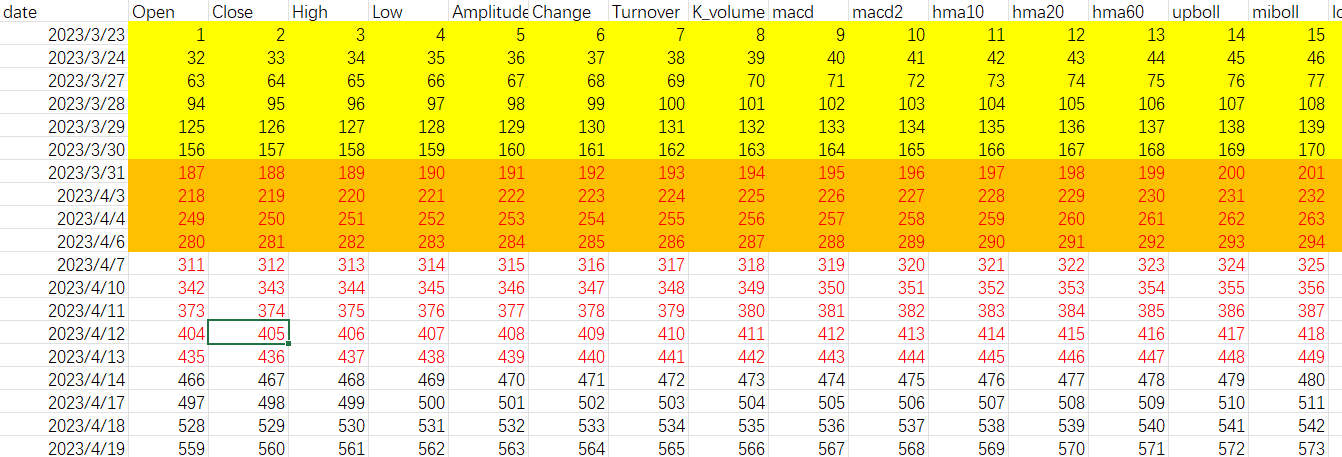

In [74]:
print(len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=1,
    shuffle=False,
    num_workers=args.num_workers,
    drop_last=True)
if len(data_loader) > 0:
    for batch in data_loader:
        first_batch = batch
        break
    print(first_batch)
else:
    print("Data loader is empty.")


34
[tensor([[[ 1.0376e+02,  1.0694e+02,  1.0291e+02,  ..., -8.6447e+01,
          -1.3502e-01,  1.0493e+02],
         [ 1.0613e+02,  1.0785e+02,  1.0469e+02,  ..., -8.6357e+01,
          -1.7560e-01,  1.0511e+02],
         [ 1.0476e+02,  1.0500e+02,  1.0348e+02,  ..., -8.6612e+01,
          -1.5036e-01,  1.0460e+02],
         ...,
         [ 8.6970e+01,  8.7700e+01,  8.6180e+01,  ..., -9.5172e+01,
          -9.0414e-02,  8.7470e+01],
         [ 8.7470e+01,  8.8050e+01,  8.5840e+01,  ..., -9.5987e+01,
          -1.1451e-01,  8.5840e+01],
         [ 8.5840e+01,  8.6320e+01,  8.5150e+01,  ..., -9.6272e+01,
          -1.2922e-01,  8.5270e+01]]], dtype=torch.float64), tensor([[[ 85.6100,  86.3200,  84.0100,  ..., -96.8166,  -0.2691,  84.1800],
         [ 92.8900,  92.8900,  84.3200,  ..., -96.5717,  -0.2988,  84.6700],
         [ 84.2400,  88.0600,  84.2400,  ..., -94.9025,  -0.2226,  88.0100],
         ...,
         [ 80.0800,  81.1700,  79.0700,  ..., -99.1954,  -0.2609,  79.4200],
      

In [76]:
from models.TimesNet import Model
import torch
import os


def build_model(args):
    # 使用 Args 实例来构建 Model 实例
    model = Model(args)
    return model

def acquire_device(args):
    if args.use_gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu) if not args.use_multi_gpu else args.devices
        device = torch.device(f'cuda:{args.gpu}')
        print(f'Use GPU: cuda:{args.gpu}')
    else:
        device = torch.device('cpu')
        print('Use CPU')
    return device

# 构建模型
device = acquire_device(args)
model = build_model(args).to(device)
model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth'), map_location=torch.device(device)))


Use GPU: cuda:0


<All keys matched successfully>

In [98]:
folder_path = './test_results/' + setting + '/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

model.eval()

Model(
  (model): ModuleList(
    (0-1): 2 x TimesBlock(
      (conv): Sequential(
        (0): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (4): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
            (5): Conv2d(32, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
          )
        )
        (1): GELU(approximate='none')
        (2): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        

In [82]:
# 第一笔数据进行预测
preds = []
trues = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # # 打印变量的值
    # print(f"Iteration {i}")
    # print("batch_x:", batch_x)
    # print("batch_y:", batch_y)
    # print("batch_x_mark:", batch_x_mark)
    # print("batch_y_mark:", batch_y_mark)

    # decoder input 
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)

    # 打印更多的变量
    # print("dec_inp:", dec_inp)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0
    outputs2 = outputs[:, -args.pred_len:, :]
    batch_y2 = batch_y[:, -args.pred_len:, :].to(device)
    outputs3 = outputs2[:, :, f_dim:]
    batch_y3 = batch_y2[:, :, f_dim:]
    break

In [104]:
# 最后一笔数据预测
preds = []
trues = []
data_loader_length = len(data_loader)
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
    if i < data_loader_length - 1 and args.pred_once:
        continue  # 跳过除了最后一批数据之外的所有批次
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    # # 打印变量的值
    # print(f"Iteration {i}")
    # print("batch_x:", batch_x)
    # print("batch_y:", batch_y)
    # print("batch_x_mark:", batch_x_mark)
    # print("batch_y_mark:", batch_y_mark)

    # decoder input 
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)

    # 打印更多的变量
    # print("dec_inp:", dec_inp)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0
    outputs2 = outputs[:, -args.pred_len:, :]
    batch_y2 = batch_y[:, -args.pred_len:, :].to(device)
    outputs3 = outputs2.detach().cpu().numpy() # 将outputs转换为numpy格式
    batch_y3 = batch_y2.detach().cpu().numpy() # 将batch_y转换为numpy格式
    
    outputs3 = outputs3[:, :, f_dim:]
    batch_y3 = batch_y3[:, :, f_dim:]
    
    pred = outputs3
    true = batch_y3
    
    preds.append(pred)
    trues.append(true)
    
    preds = np.array(preds) # 将预测结果转换为numpy格式
    trues = np.array(trues) # 将真实结果转换为numpy格式
    print('test shape:', preds.shape, trues.shape)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1]) # 将预测结果转换为三维矩阵
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
    print('test shape:', preds.shape, trues.shape)
    
    

test shape: (1, 1, 20, 1) (1, 1, 20, 1)
test shape: (1, 20, 1) (1, 20, 1)


In [105]:
mae, mse, rmse, mape, mspe = metric(preds, trues)
print('mse:{}, mae:{}'.format(mse, mae))
f = open("result_long_term_forecast.txt", 'a')
f.write(setting + "  \n")
f.write('mse:{}, mae:{}'.format(mse, mae))
f.write('\n')
f.write('\n')
f.close()

NameError: name 'metric' is not defined

In [11]:
with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        # # 打印变量的值
        # print(f"Iteration {i}")
        # print("batch_x:", batch_x)
        # print("batch_y:", batch_y)
        # print("batch_x_mark:", batch_x_mark)
        # print("batch_y_mark:", batch_y_mark)

        # decoder input 将batch_y后面再拼接形状跟batch_y相同且全为0的矩阵。
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
        # encoder - decoder
        if args.use_amp:
            with torch.cuda.amp.autocast():
                if args.output_attention:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if args.output_attention:
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

            else:
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

        f_dim = -1 if args.features == 'MS' else 0
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :].to(device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
        if test_data.scale and args.inverse:
            shape = outputs.shape
            outputs = test_data.inverse_transform(outputs.squeeze(0)).reshape(shape)
            batch_y = test_data.inverse_transform(batch_y.squeeze(0)).reshape(shape)

        outputs = outputs[:, :, f_dim:]
        batch_y = batch_y[:, :, f_dim:]

        pred = outputs
        true = batch_y

        preds.append(pred)
        trues.append(true)
        if i % 20 == 0:
            input = batch_x.detach().cpu().numpy()
            if test_data.scale and self.args.inverse:
                shape = input.shape
                input = test_data.inverse_transform(input.squeeze(0)).reshape(shape)
            gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
            pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
            visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

preds = np.array(preds)
trues = np.array(trues)
print('test shape:', preds.shape, trues.shape)
preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
print('test shape:', preds.shape, trues.shape)

# result save
folder_path = './results/' + setting + '/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

mae, mse, rmse, mape, mspe = metric(preds, trues)
print('mse:{}, mae:{}'.format(mse, mae))
f = open("result_long_term_forecast.txt", 'a')
f.write(setting + "  \n")
f.write('mse:{}, mae:{}'.format(mse, mae))
f.write('\n')
f.write('\n')
f.close()

np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
np.save(folder_path + 'pred.npy', preds)
np.save(folder_path + 'true.npy', trues)

NameError: name 'self' is not defined

# B

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./tensorboard_logs/